# Apartment Model Example

The following example illustrates this method.  The method requires a linear algebra library:

In [179]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def prfloat(x,n=10,m=4,f="g"):
    if x == 0.0:
        return " "*(n-1) + "0"
    else:
        return f"%{n}.{m}f"%x
def DUMP(_a,_b=None):
    if _b == None: 
        _t = str(eval(_a))
        if _t.find('\n') > 0:
            print(f"{_a} = \n{_t}")
        else:
            print(f"{_a} = {eval(_a)}")
    else:
        _t = str(eval(_b))
        if _t.find('\n') > 0:
            print(f"{_b} = # {_a}\n{_t}")
        else:
            print(f"{_b} = {eval(_b)} # {_a}")
np.set_printoptions(precision=4,floatmode='fixed',formatter={'float':lambda x: prfloat(x,10,4,"f")})

In [180]:
# Table 3: Building design parameters
N = 2 # 10 floors
M = 2 # 20 units per floor
X = 24 # unit width (ft)
Y = 40 # unit depth (ft)
Z = 8 # unit height (ft)
W = 6 # corridor width (ft)
F = 1 # floor thickness (ft)
I = 1 # Wall thickness (ft)

Kx = 0 # corridor is not exterior
Kd = 1 # corridor is double-sided
omega = 0.5 # exterior window/wall ratio
beta = .8 # fraction of units that are occupied
alpha = .75 # Fraction of area in walls that is insulation compared to building material
a = .5 # fraction of heat gain that goes to zone instead of mass
b = 1-a # fraction of heat gain that is taken up directly by mass





In [181]:
# Table 5: Derived building properties
A = X*Y # unit floor area (sf)
Ad = 3*6.7 # unit door area (sf)
Aw_unit = omega*X*Z # unit window area (sf)
Aw_core = omega*W*Z # core window area (sf)
Au = Y*Z # unit-unit wall area (sf)
Ao = X*Z - Aw_unit # unit-outdoor wall area (sf)
Ac = X*Z - Ad # unit-core wall area (sf)
Ah = W*Z # Core exterior wall ares (sf)
Ah_w = Ah - Aw_core # Core exterior wall with window (sf)
Ah_d = Ah - Ad # Core exterior wall with door (sf)


# components
Xl = M * X * (1 - .5 * Kd)
Al = Xl * Z
Ac_sides = 2*Ah*(1-Kx) # ??? Ah may not include window or door
Ac_aptwall = N*Al*(Kd+1) # ??? do you include doors
Ac_external = N*Al*(1-Kx)*(1-Kd)
Ac_floor = N*Xl*W
Ac_ceiling = N*Xl*W



In [182]:
# Table 4: Building thermal properties
R_ext = 20
R_int = 5
R_window = 2
R_door = 4.75
R_mass = R_ext/2
R_floor = 10
R_roof = 38
R_ground = 60

R_C_window = (Ah_w/R_ext)+(Aw_core/R_window)
R_C_door = (Ah_d/R_ext)+(Ad/R_door)

In [183]:
# Table 5: Derived building properties
V = X*Y*Z # unit volume (cf)
V_outsidewalls = 2*N*I*(Al+Au*(Kd+1)+Ah*(Kx-1))
V_innerwalls = N*I*(M-1-Kd)*Au
V_unitfloors = N*A*F
V_unitceiling = A*F
V_corewalls = N*Al*I*(2*Kd+(1-Kd)*(1-Kx))
V_corefloor = N*Xl*W*F
V_coreceiling = Xl*W*F


V_totalwalls = V_outsidewalls + V_innerwalls  +V_corewalls 
V_totalfloors=  V_unitfloors + V_unitceiling+ V_corefloor  +V_coreceiling


In [184]:
# C_int = 2000 # occupied unit interior thermal capacitance (Btu/degF)

Sint = 10.0 # Unit interior mass heat capacity per Apartment floor area (Btu/degF.sf)
Sfloor = 150.0

c_building = .3 # specific heat of wood (hardwood) (Btu/lbm.F)
rho_material = 45 # density of wood (hardwood) (lbm/cf)
rho_wallmaterial = 45 # density of wood (hardwood) (lbm/cf)
rho_floormaterial = 45 # density of wood (hardwood) (lbm/cf)
rho_air = 0.07489 # density of air at 70 F (lbm/cf)
c_air = 0.2404 # specific heat of air at 70 F (Btu/lbm.F)
rho_insulation = 1



Sair = rho_air*c_air
Cint = Sint*A


M_walls = V_totalwalls *(alpha*rho_insulation+(1-alpha)*rho_wallmaterial)
c_walls = .3
M_floors = V_totalfloors*rho_floormaterial
c_floors =.3


In [185]:
# set zone heat gains
Q_Rad_A = 0 # solar gains to occupied apartments (computed from weather data)
Q_Vent_A = 0 # ventilation gains to occupied apartments (computed from weather data)
Q_Enduse_A = 0 # electric load gains to occupied aparments (computed from equipment data)

Q_Rad_U = 0 # solar gains to unoccupied apartments (computed from weather data)
Q_Vent_U = 0 # ventilation gains to occupied apartments (computed from weather data)

Q_Rad_C = 0 # solar gains to core spaces (computed from weather data)
Q_Vent_C = 0 # ventilation gains to core spaces (computed from weather data)
Q_Enduse_C = 0 # electric load gains to core spaces (computed from equipment data)

Q_Gains_A = Q_Rad_A + Q_Vent_A + Q_Enduse_A
Q_Gains_U = Q_Rad_U + Q_Vent_U 
Q_Gains_C = Q_Rad_C + Q_Vent_C + Q_Enduse_C
Q_Gains_M = 0


In [186]:
# set outdoor temperature 
T_O = 100.0 # computed from weather data relative the apartment setpoint (e.g., T_A = 40 degF - T_O)
unit_temperature = 55.0
vacant_temperature = 65.0
core_temperature = 60.0
mass_temperature = 45.0
building_setpoint_temp = 70.0
unit_mode = 0
vacant_mode = 0
core_mode = 0

In [187]:
# Building mode
m = np.sign(building_setpoint_temp - T_O) # -1 for cooling, +1 for heating

The HVAC system capabilities are

In [188]:
# set heat/cool constraints
u_min = np.array([[-np.inf],[-np.inf],[-np.inf],[-np.inf]])
u_max = np.array([[np.inf],[np.inf],[np.inf],[np.inf]])

# temperature setpoints
T_unoccupied = 10 # unoccupied zone temperature setpoint offset (degF)
T_core = 5 # core zone temperature setpoint offset (degF)

In [189]:
# Table 7: Capacitance calculations
C_A = N * M * beta * V * Sair
C_U = N * M * (1-beta) * V * Sair
C_C = N * Xl * Ah * Sair
C_M = M_walls*c_walls + M_floors*c_floors + N*M*Sint*A

print("Table 7: Capacitance calculations (Btu/degF)\n\n"
     + "C_A  C_U  C_C  C_M\n"
     + "---- ---- ---- ----\n"
     + "%4.0f %4.0f %4.0f %4.0f"
     % (C_A,C_U,C_C,C_M))

Table 7: Capacitance calculations (Btu/degF)

C_A  C_U  C_C  C_M
---- ---- ---- ----
 442  111   41 97166


In [190]:
# Table 6: Conductance calculations
U_OA_windowwall = N * M * beta * ((Ao/R_ext)+(Aw_unit))
U_OU_windowwall = ((1-beta)/beta) * U_OA_windowwall
U_OA_sidewall = 2*N*beta*(1+Kd)*(Au/R_ext)
U_OU_sidewall = ((1-beta)/beta) * U_OA_sidewall
U_OA_roof = M*beta*(A/(R_floor+R_roof))
U_OU_roof = ((1-beta)/beta) * U_OA_roof
U_OA_floor = M*beta*(A/(R_floor+R_ground))
U_OU_floor = ((1-beta)/beta) * U_OA_floor
U_UA_innerwalls = 2*N*M*beta*(1-beta)*(Au/R_int)
U_UA_floor = (N-1)*beta*M*(1-beta)*(A/R_floor)
U_UA_ceiling = (N-1)*beta*M*(1-beta)*(A/R_floor)
U_AU_floor = U_UA_ceiling
U_UA_ceiling = U_UA_floor
U_OC_sides = 2*N*(1-Kx)*(R_C_window+R_C_door)
U_OC_wall = (Al/R_ext)*(1-Kd)
U_OC_floor = Al/(R_floor+R_ground)
U_OC_roof = Al/(R_floor+R_roof)

In [191]:
# Occupied Apartment
U_OA = U_OA_windowwall + U_OA_sidewall + U_OA_floor + U_OA_roof
U_UA = U_UA_innerwalls + U_UA_floor + U_UA_ceiling
U_CA = N*M*beta*((Ac/((1-Kx)*R_int+Kx*R_ext)+(Ad/R_door)))
U_MA = N*M*beta*((2*(A+Au)+Ao+Ac)/R_mass)

# Unoccupied Apartment
U_OU = U_OU_windowwall + U_OU_sidewall + U_OU_floor + U_OU_roof
U_UA = U_UA
U_UC = ((1-beta)/beta)*U_CA
U_MU = ((1-beta)/beta)*U_MA

# Building Core
U_OC = U_OC_sides + U_OC_wall + U_OC_floor + U_OC_roof
U_CA = U_CA
U_UC = U_UC
U_MC = (Ac_sides + Ac_aptwall + Ac_external + Ac_floor + Ac_ceiling)/R_mass

# Building Mass
U_OM = (2*N*(Al*(1+Kx)+Au*(1+Kd)+Ah*(1-Kx)+W*Xl*Kx))/R_mass
U_MA = U_MA
U_MU = U_MU
U_MC = U_MC


print("Table 6a: Conductance calculations Occupied Apartments (Btu/degF.h)\n" + 
      "U_OA U_UA U_CA U_MA\n" +
      "---- ---- ---- ----\n" +
      "%4.0f %4.0f %4.0f %4.0f" 
      % (U_OA,U_UA,U_CA,U_MA))
print("\nTable 6b: Conductance calculations Unoccupied Apartments (Btu/degF.h)\n" + 
      "U_OU U_UA U_UC U_MU\n" +
      "---- ---- ---- ----\n" +
      "%4.0f %4.0f %4.0f %4.0f" 
      % (U_OU,U_UA,U_UC,U_MU))
print("\nTable 6c: Conductance calculations Building Core (Btu/degF.h)\n" + 
      "U_OC U_CA U_UC U_MC\n" +
      "---- ---- ---- ----\n" +
      "%4.0f %4.0f %4.0f %4.0f" 
      % (U_OC,U_CA,U_UC,U_MC))
print("\nTable 6d: Conductance calculations Building Mass (Btu/degF.h)\n" + 
      "U_OM U_MA U_MU U_MC\n" +
      "---- ---- ---- ----\n" +
      "%4.0f %4.0f %4.0f %4.0f" 
      % (U_OM,U_MA,U_MU,U_MC))

Table 6a: Conductance calculations Occupied Apartments (Btu/degF.h)
U_OA U_UA U_CA U_MA
---- ---- ---- ----
 479  143  124  905

Table 6b: Conductance calculations Unoccupied Apartments (Btu/degF.h)
U_OU U_UA U_UC U_MU
---- ---- ---- ----
 120  143   31  226

Table 6c: Conductance calculations Building Core (Btu/degF.h)
U_OC U_CA U_UC U_MC
---- ---- ---- ----
  82  124   31  144

Table 6d: Conductance calculations Building Mass (Btu/degF.h)
U_OM U_MA U_MU U_MC
---- ---- ---- ----
 352  905  226  144


In [192]:
# Thermal conditions
q = np.array([[Q_Gains_A], [Q_Gains_U], [Q_Gains_C], [Q_Gains_M] ,[T_O]])
print("Thermal conditions\n\n"
     + " Q_A  Q_U  Q_C Q_M  T_O \n"
     + "       kBtu/h      degF\n"
     + "---- ---- ---- ---- ----")
print("%4.0f %4.0f %4.0f %4.0f %4.0f"
     % (q[0],q[1],q[2],q[3],q[4]))

Thermal conditions

 Q_A  Q_U  Q_C Q_M  T_O 
       kBtu/h      degF
---- ---- ---- ---- ----
   0    0    0    0  100


In [193]:

# compute the solution matrices
A = np.array([ 
      [-(U_OA+U_UA+U_CA+U_MA)/C_A,                   U_UA/C_A,                   U_CA/C_A,                   U_MA/C_A],
      [                  U_UA/C_U, -(U_OU+U_UA+U_UC+U_MU)/C_U,                   U_UC/C_U,                   U_MU/C_U],
      [                  U_CA/C_C,                   U_UC/C_C, -(U_OC+U_CA+U_UC+U_MC)/C_C,                   U_MC/C_C],
      [                  U_MA/C_M,                   U_MU/C_M,                   U_MC/C_M, -(U_OM+U_MA+U_MU+U_MC)/C_M]
    ])
DUMP("A")

A = 
[[   -3.7309     0.3240     0.2793     2.0452]
 [    1.2960    -4.7029     0.2793     2.0452]
 [    2.9787     0.7447    -9.1729     3.4715]
 [    0.0093     0.0023     0.0015    -0.0167]]


In [194]:

B1 = np.array([ 
       [  a/C_A,     0,     0, 0, U_OA/C_A],
       [      0, a/C_U,     0, 0, U_OU/C_U],
       [      0,     0, a/C_C, 0, U_OC/C_C],
       [  b/C_M, b/C_M, b/C_M, 1/C_M, U_OM/C_M]
      ])
DUMP("B1")

B1 = 
[[    0.0011          0          0          0     1.0824]
 [         0     0.0045          0          0     1.0824]
 [         0          0     0.0121          0     1.9780]
 [    0.0000     0.0000     0.0000     0.0000     0.0036]]


In [195]:
B2 = np.array([ 
       [ a/C_A,     0,     0,     0],
       [     0, a/C_U,     0,     0],
       [     0,     0, a/C_C,     0],
       [ b/C_M, b/C_M, b/C_M, 1/C_M]
      ])
DUMP("B2")

B2 = 
[[    0.0011          0          0          0]
 [         0     0.0045          0          0]
 [         0          0     0.0121          0]
 [    0.0000     0.0000     0.0000     0.0000]]


In [196]:
DUMP('q')

q = 
[[         0]
 [         0]
 [         0]
 [         0]
 [  100.0000]]


In [197]:
# initial temperature
T0 = np.array([[unit_temperature],[vacant_temperature],[core_temperature],[mass_temperature]])

T_set = np.full((4,1),building_setpoint_temp) - m * np.array([[0],[T_unoccupied],[T_core],[0]])

# Steady state temperatures without HVAC heating/cooling 
T_eq = -LA.inv(A) @ B1 @ q 

B1Q = B1 @ q
DUMP('B1')
DUMP('q')
DUMP('B1Q')

dT = A @ T_eq + B1 @ q

print("Temperatures (degF)\n\n"
     + "Zone   T(0) dT/dt  Teq   Set \n"
     + "----- ----- ----- ----- -----")
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_A',T0[0],dT[0],T_eq[0],T_set[0]))
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_U',T0[1],dT[1],T_eq[1],T_set[1]))
print("%-5.5s %5.1f %5.1f %5.1f %5.1f" % ('T_C',T0[2],dT[2],T_eq[2],T_set[2]))
print("%-5.5s %5.1f %5.1f %5.1f   --" % ('T_M',T0[3],dT[3],T_eq[3]))

B1 = 
[[    0.0011          0          0          0     1.0824]
 [         0     0.0045          0          0     1.0824]
 [         0          0     0.0121          0     1.9780]
 [    0.0000     0.0000     0.0000     0.0000     0.0036]]
q = 
[[         0]
 [         0]
 [         0]
 [         0]
 [  100.0000]]
B1Q = 
[[  108.2375]
 [  108.2375]
 [  197.8033]
 [    0.3623]]
Temperatures (degF)

Zone   T(0) dT/dt  Teq   Set 
----- ----- ----- ----- -----
T_A    55.0   0.0 100.0  70.0
T_U    65.0   0.0 100.0  80.0
T_C    60.0   0.0 100.0  75.0
T_M    45.0  -0.0 100.0   --


In [198]:
# Solve for Equilibrium temperature for Building Mass explicitly
Q_HVAC_A = -((-T_set[0]*(U_OA+U_UA+U_CA+U_MA)+U_UA*T_set[1]+U_CA*T_set[2]+U_OA*T_O)/a)-q[0]
Q_HVAC_U = -((T_set[0]*U_UA-T_set[1]*(U_OU+U_UA+U_UC+U_MU)+U_UC*T_set[2]+U_OU*T_O)/a)-q[1]
Q_HVAC_C = -((T_set[0]*(U_CA)+U_UC*T_set[1]-(U_OC+U_CA+U_UC+U_MC)*T_set[2]+U_OC*T_O)/a)-q[2]

T_M_eq = (T_set[0]*(U_MA)+U_MU*T_set[1]+U_MC*T_set[2]+U_OM*T_O + (1-a) * (q[0]+q[1]+q[2] +Q_HVAC_A+Q_HVAC_U+Q_HVAC_C)+q[3])/(U_OM+U_MA+U_MU+U_MC+((1-a)/a)*(U_MA+U_MU+U_MC))

print(T_M_eq)

# replace default setpoint value for Building Mass
T_set[3] = T_M_eq



[   69.2116]


In [204]:

# solve for the required control
u_req = -LA.inv(B2) @ (A @ T_set + B1 @ q)


B2inv = -LA.inv(B2)
ATset = A @ T_set
# DUMP('A')
# DUMP('T_set')
# DUMP('ATset')

ATsetB1Q = ATset + B1Q
DUMP('B1Q')
DUMP('ATsetB1Q')

# DUMP('C_M')
# DUMP('B2')
# DUMP('B2inv')
DUMP('u_req')
# DUMP('u_min')


# constrain the solution

# u = u_req
u_b = np.array(
            [np.hstack((u_req,u_min)).max(axis=1)]
            ).transpose()

DUMP('u_max')
DUMP('u_b')

u = np.array(
    [np.hstack(
        (u_max,u_b
        )).min(axis=1)
    ]).transpose()
DUMP('u')

u_shortfall = u_req - u

# compute the temperature changes
dT = A @ T0 + B1 @ q + B2 @ u

# compute time to change dTmax degF
dTmax = 1.0
deltat = dTmax * 3600/max(abs(dT))[0]
# show me
print("shortfall = %.0f kBtu/h" % (sum(u_req - u)))
print("dTA = %.2f degF/h" % (dT[0]))
print("dTU = %.2f degF/h" % (dT[1]))
print("dTC = %.2f degF/h" % (dT[2]))
print("dTM = %.2f degF/h" % (dT[3]))
print("dt = %.0f sec" % (deltat))

B1Q = 
[[  108.2375]
 [  108.2375]
 [  197.8033]
 [    0.3623]]
ATsetB1Q = 
[[   35.4952]
 [  -14.7740]
 [   18.1860]
 [    0.1526]]
u_req = 
[[-31410.0513]
 [ 3268.4267]
 [-1508.7215]
 [   -0.0000]]
u_max = 
[[       inf]
 [       inf]
 [       inf]
 [       inf]]
u_b = 
[[-31410.0513]
 [ 3268.4267]
 [-1508.7215]
 [   -0.0000]]
u = 
[[-31410.0513]
 [ 3268.4267]
 [-1508.7215]
 [   -0.0000]]
shortfall = 0 kBtu/h
dTA = -2.60 degF/h
dTU = -2.60 degF/h
dTC = -2.31 degF/h
dTM = 0.21 degF/h
dt = 1382 sec


In [200]:
# Verify steady state temperatures with HVAC
T_eq_hvac = - LA.inv(A)@(B1@q+B2@u)
DUMP("T_eq_hvac")

T_eq_hvac = 
[[   70.0000]
 [   80.0000]
 [   75.0000]
 [   69.2116]]


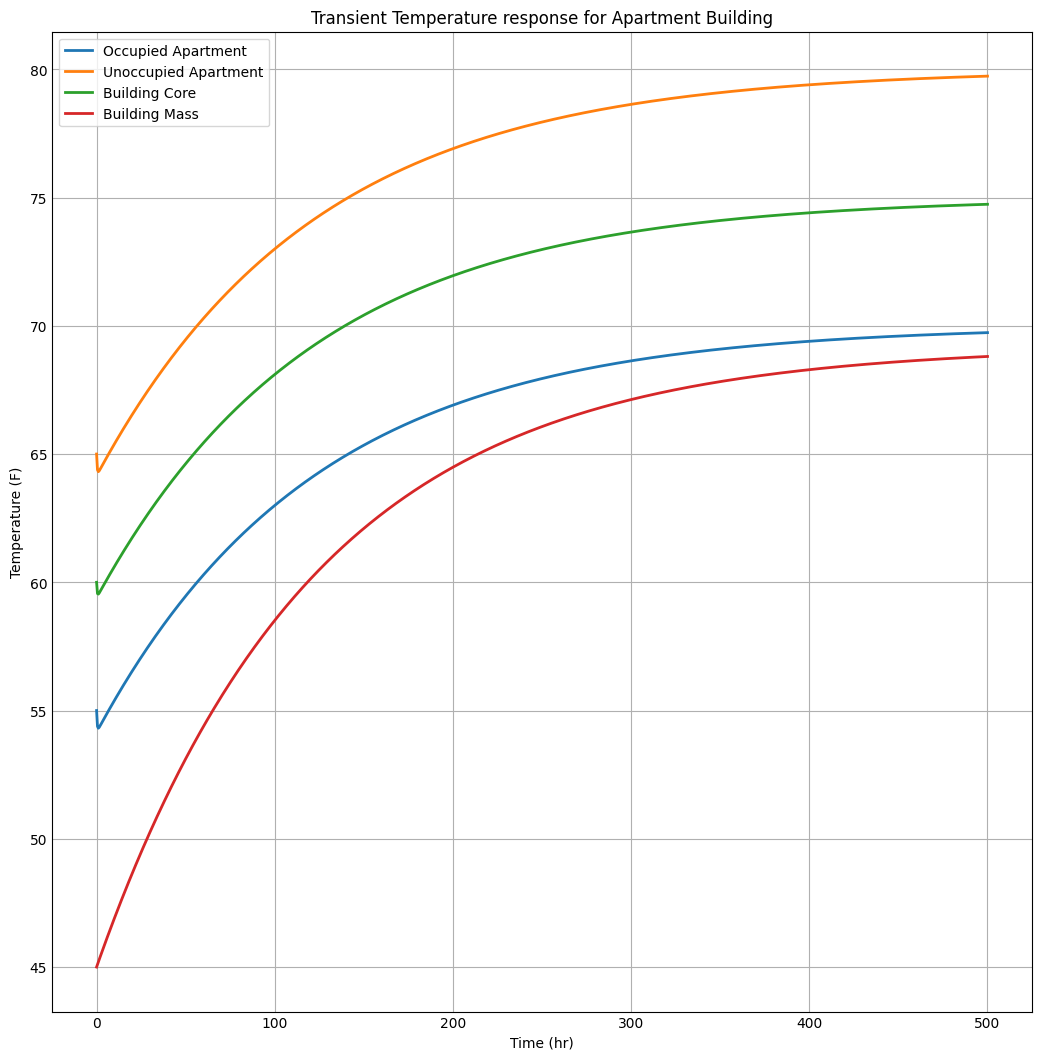

Equilibrium Temperature (degF)

               Field             Occupied           Unoccupied                 Core                 Mass
               -----                    -                    -                    -                    -
Initial Temp [C]                     55.0                 65.0                 60.0                 45.0
Set-point Temp [C]                   70.0                 80.0                 75.0                 69.2
Actual Equilibrium Temp [C]                 70.0                 80.0                 75.0                 69.2
Gains [Btu/h]                         0.0                  0.0                  0.0                  0.0
HVAC EQ Power [Btu/h]             -31410.1               3268.4              -1508.7
HVAC Shortfall [Btu/h]                  0.0                  0.0                  0.0


In [201]:

# def f(time):
#        t = [0,time]
#        y = odeint(dTdt,T0.transpose()[0],t,args=(A,B1,B2,q,u))
#        return [y[-1]][0]

def dTdt (T,t,A,B1,B2,q,u):
       Ttrans = np.array([T]).transpose()
       dTdt = A @ Ttrans + B1 @ q + B2 @ u
       return dTdt.transpose()[0]

plt.style.use('_mpl-gallery')

# make data
start = 0
end = 500
steps = 1000
t = np.linspace(start, end, steps)

yt = odeint(dTdt,T0.transpose()[0],t,args=(A,B1,B2,q,u))

yA = yt[:,0]
yU = yt[:,1]
yC = yt[:,2]
yM = yt[:,3]

# plot
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(t, yA, linewidth=2.0, label='Occupied Apartment')
ax.plot(t, yU, linewidth=2.0, label='Unoccupied Apartment')
ax.plot(t, yC, linewidth=2.0, label='Building Core')
ax.plot(t, yM, linewidth=2.0, label='Building Mass')


ax.set_xlabel('Time (hr)')
ax.set_ylabel('Temperature (F)')
ax.set_title('Transient Temperature response for Apartment Building')


plt.legend()

plt.show()


# Tinf = f(100000)

print("Equilibrium Temperature (degF)\n")
print("%20.30s %20.30s %20.30s %20.30s %20.30s" % ('Field', 'Occupied', 'Unoccupied' ,'Core' ,'Mass'))
print("%20.30s %20.1s %20.1s %20.1s %20.1s" % ('-----', '-----', '-----' ,'-----' ,'-----'))
print("%-20.30s %20.1f %20.1f %20.1f %20.1f" % ('Initial Temp [C]',T0[0],T0[1],T0[2],T0[3]))
print("%-20.30s %20.1f %20.1f %20.1f %20.1f" % ('Set-point Temp [C]',T_set[0],T_set[1],T_set[2],T_set[3]))
print("%-20.30s %20.1f %20.1f %20.1f %20.1f" % ('Actual Equilibrium Temp [C]',T_eq_hvac[0],T_eq_hvac[1],T_eq_hvac[2],T_eq_hvac[3]))
print("%-20.30s %20.1f %20.1f %20.1f %20.1f" % ('Gains [Btu/h]',q[0],q[1],q[2],q[3]))
print("%-20.30s %20.1f %20.1f %20.1f" % ('HVAC EQ Power [Btu/h]',u[0],u[1],u[2]))
print("%-20.30s %20.1f %20.1f %20.1f" % ('HVAC Shortfall [Btu/h]',u_shortfall[0],u_shortfall[1],u_shortfall[2]))



In [202]:
DUMP("occupied zone heat capacity (Btu/degF)","C_A")
DUMP("unoccupied zone heat capacity (Btu/degF)","C_U")
DUMP("core zone heat capacity (Btu/degF)","C_C")
DUMP("mass heat capacity (Btu/degF)","C_M")
DUMP("occupied zone solar gain","Q_Rad_A")
DUMP("occupied zone ventilation gain","Q_Vent_A")
DUMP("occupied zone equipment gain","Q_Enduse_A")
DUMP("unoccupied zone solar gain","Q_Rad_U")
DUMP("core zone solar gain","Q_Rad_C")
DUMP("core zone ventilation gain","Q_Vent_C")

C_A = 442.455392256 # occupied zone heat capacity (Btu/degF)
C_U = 110.61384806399997 # unoccupied zone heat capacity (Btu/degF)
C_C = 41.480193024 # core zone heat capacity (Btu/degF)
C_M = 97166.4 # mass heat capacity (Btu/degF)
Q_Rad_A = 0 # occupied zone solar gain
Q_Vent_A = 0 # occupied zone ventilation gain
Q_Enduse_A = 0 # occupied zone equipment gain
Q_Rad_U = 0 # unoccupied zone solar gain
Q_Rad_C = 0 # core zone solar gain
Q_Vent_C = 0 # core zone ventilation gain


In [203]:
DUMP("number of floors","N")
DUMP("number of units per floor","M")
DUMP("unit width (ft)","X")
DUMP("unit depth (ft)","Y")
DUMP("unit height (ft)","Z")
DUMP("core width (ft)","W")
DUMP("unit floor area (sf)","A")
DUMP("unit window area (sf)","Aw_unit")
DUMP("unit door area (sf)","Ad")
DUMP("unit wall area (sf)","Au")
DUMP("unit exterior wall area (sf)","Ao")
DUMP("unit core wall area (sf)","Ac")
DUMP("unit volume (cf)","V")
DUMP("occupancy factor (pu)","beta")
DUMP("indoor core fraction (pu)","Kx")
DUMP("indoor core double loading fraction (pu)","Kd")
DUMP("floor thickness (ft)","F")
DUMP("volumetric air density (lb/cf)","rho_air")
DUMP("air specific heat capacity (Btu/degF/cf)","Sair")
DUMP("interior mass loading (Btu/degF/sf)","Sint")
DUMP("interior heat capacity (Btu/degF)","Cint")
DUMP("density of floor mass (lb/cf)","Sfloor")

N = 2 # number of floors
M = 2 # number of units per floor
X = 24 # unit width (ft)
Y = 40 # unit depth (ft)
Z = 8 # unit height (ft)
W = 6 # core width (ft)
A = # unit floor area (sf)
[[   -3.7309     0.3240     0.2793     2.0452]
 [    1.2960    -4.7029     0.2793     2.0452]
 [    2.9787     0.7447    -9.1729     3.4715]
 [    0.0093     0.0023     0.0015    -0.0167]]
Aw_unit = 96.0 # unit window area (sf)
Ad = 20.1 # unit door area (sf)
Au = 320 # unit wall area (sf)
Ao = 96.0 # unit exterior wall area (sf)
Ac = 171.9 # unit core wall area (sf)
V = 7680 # unit volume (cf)
beta = 0.8 # occupancy factor (pu)
Kx = 0 # indoor core fraction (pu)
Kd = 1 # indoor core double loading fraction (pu)
F = 1 # floor thickness (ft)
rho_air = 0.07489 # volumetric air density (lb/cf)
Sair = 0.018003556 # air specific heat capacity (Btu/degF/cf)
Sint = 10.0 # interior mass loading (Btu/degF/sf)
Cint = 9600.0 # interior heat capacity (Btu/degF)
Sfloor = 150.0 # density of floor mass (lb/cf)
